# Simulation of a Serial Batch Reactor Network

The purpose of this tutorial is to implement and simulate a serial batch chemical reactor network using the libraries `pyMC` and `CRONOS`. 

The network consists of two batch reactors connected in series. The reaction mechanism characterizing the two reactors is the same:
$$\begin{equation*}
    2{\sf A} \xrightarrow{k_1} {\sf B} \xrightarrow{k_2} {\sf C}
\end{equation*}$$
where component ${\sf B}$ is the desired product.

The reactor dynamics are ordinary differential equations (ODEs) that describe the evolution of component molar concentrations in continuous time:
$$\begin{align*}
        \dot{c}_{{\sf A},j}(t) &= -2k_{1,j}(T_j)\,c_{{\sf A},j}(t)^2\\ 
        \dot{c}_{{\sf B},j}(t) &= k_{1,j}(T_j)\,c_{{\sf A},j}(t)^2 - k_{2,j}(T_j)\,c_{{\sf B},j}(t)\\ 
        \dot{c}_{{\sf C},j}(t) &= k_{2,j}(T_j)\,c_{{\sf B},j}(t)
\end{align*}$$
where $c_{i,j}(t)$ ($\text{kmol m}^{-3}$) describes the molar concentration of component $i={\sf A},{\sf B},{\sf C}$ in reactor $j=1,2$; and $T_j$ (K) the temperature  in reactor $j$. 

The system adheres to Arrhenius kinetics:
$$\begin{equation*}
    k_{r,j}(T) = k^\circ_{r,j} \exp\left(-\frac{E_{r,j}}{RT}\right)
\end{equation*}$$
where $T$ (K) is the reaction temperature; $k_{r,j}$ the temperature-dependent rate constant of reaction step $r=1,2$ for reactor $j$; $k^\circ_{r,j}$ the pre-exponential factor; $E_{r,j}$ the activation energy; and $R$ denotes the ideal gas constant. The kinetic parameters are reported in the table below. Note that the kinetic parameters for the two reactors are different but known with certainty. The volume of both reactors is assumed to be $V=1~\text{m}^3$. 

Parameter | Reaction 1 | Reaction 2
:-------- | :-------: | :-------:
$k^\circ_r\ (\text{m}^3,\text{kmol},\text{min})$ | $6.66 \times 10^{-3}$ | $1.03$
$E_r (\text{kJ\: mol}^{-1})$ | $2.52$ | $5.00$

Each reactor $j=1,2$ is operated over a time horizon, $t \in [0, \tau_j]$, where $\tau_j$ is the batch time. The initial concentration of the first reactor is $\textbf{c}_1(0)=[2\  0\ 0]^\intercal$, while we assume for the second reactor that the initial concentration is equal to the composition present in the first reactor at the batch endpoint, subject to a separation step to completely remove the (inert) component ${\sf C}$, $\textbf{c}_2(0)=[c_{{\sf A},1}(\tau_1)\ c_{{\sf B},1}(\tau_1)\ 0]^\intercal$.

The process inputs of interest are the temperature and batch time of both reactors, $(T_i,\tau_i)\in [250,1000] \times [250, 800]$. The process outputs of interest are the molar purity of component ${\sf C}$ at the end of operating the second batch reactor, to ensure the efficacy of the separation:
$$\begin{align*}
    \frac{c_{{\sf C},1}(\tau_1)}{c_{{\sf A},1}(\tau_1) + c_{{\sf B},1}(\tau_1) + c_{{\sf C},1}(\tau_1)}\\
\end{align*}$$
and the molar purity of component ${\sf B}$ at the end of operating the second batch reactor, to maximize production:
$$\begin{align*}
    \frac{c_{{\sf B},2}(\tau_2)}{c_{{\sf A},2}(\tau_2) + c_{{\sf B},2}(\tau_2) + c_{{\sf C},2}(\tau_2)}
\end{align*}$$

We start by importing both the `PyMC` and `CRONOS` libraries:

In [1]:
import pymc
import cronos

Next, we define the DAGs of the right-hand side and initial value functions as well as the state-dependent functions:

In [2]:
IVPDAG = pymc.FFGraph()

# States
cA  = pymc.FFVar(IVPDAG, "cA")
cB  = pymc.FFVar(IVPDAG, "cB")
cC  = pymc.FFVar(IVPDAG, "cC")

# Parameters
tau = pymc.FFVar(IVPDAG, "tau")
T   = pymc.FFVar(IVPDAG, "T")

# Constants
kr1 = pymc.FFVar(IVPDAG, "kr1")
Ea1 = pymc.FFVar(IVPDAG, "Ea1")
kr2 = pymc.FFVar(IVPDAG, "kr2")
Ea2 = pymc.FFVar(IVPDAG, "Ea2")
cA0 = pymc.FFVar(IVPDAG, "cA0")
cB0 = pymc.FFVar(IVPDAG, "cB0")
cC0 = pymc.FFVar(IVPDAG, "cC0")

An environment `ODESLV` is created and populated with the parametric initial value problem:

In [3]:
IVP = cronos.ODESLV()
IVP.set_dag( IVPDAG )
IVP.set_time( [0,1] ) # normalized time horizon
IVP.set_parameter( [tau,T,cA0,cB0,cC0] )
IVP.set_constant( [kr1,Ea1,kr2,Ea2] )
IVP.set_state( [cA,cB,cC] )

R = 8.314 # J/mol·K
k1 = kr1*pymc.exp(-Ea1/(R*T))
k2 = kr2*pymc.exp(-Ea2/(R*T))
dcA = tau*(-2*k1*cA**2)
dcB = tau*(k1*cA**2-k2*cB)
dcC = tau*(k2*cB)
IVP.set_differential( [dcA,dcB,dcC] )
IVP.set_initial( [cA0,cB0,cC0] )
IVP.set_function( [cA,cB,cC] ) # batch-end concentrations 

IVP.setup()

A simulation of the first reactor for a batch duration $\tau=400~\rm min$ and temperature $T=500~\rm K$ gives the following results:

In [4]:
IVP.options.DISPLEVEL = 1 # displays numerical integration results
IVP.options.RESRECORD = 200 # record 200 points along time horizon
IVP.solve_state( [600,750,2,0,0], [6.66e-3,2.52e3,1.03,5e3] )
IVP.solve_sensitivity( [600,750,2,0,0], [6.66e-3,2.52e3,1.03,5e3] )
IVP.solve_adjoint( [600,750,2,0,0], [6.66e-3,2.52e3,1.03,5e3] )

 @t = 0.000000e+00 :
  x[0] = 2.000000e+00
  x[1] = 0.000000e+00
  x[2] = 0.000000e+00
 @t = 1.000000e+00 :
  x[0] = 1.713773e-01
  x[1] = 2.845488e-04
  x[2] = 9.140268e-01
  f[0] = 1.713773e-01
  f[1] = 2.845488e-04
  f[2] = 9.140268e-01
 No STEPS    248
 No EVALATIONS   RHS: 365   JAC: 0
 CPU TIME (SEC)     0.00061

 @t = 0.000000e+00 :
  x[0] = 2.000000e+00
  x[1] = 0.000000e+00
  x[2] = 0.000000e+00
  xp[0][0] = 0.000000e+00
  xp[0][1] = 0.000000e+00
  xp[0][2] = 0.000000e+00
  xp[1][0] = 0.000000e+00
  xp[1][1] = 0.000000e+00
  xp[1][2] = 0.000000e+00
  xp[2][0] = 1.000000e+00
  xp[2][1] = 0.000000e+00
  xp[2][2] = 0.000000e+00
  xp[3][0] = 0.000000e+00
  xp[3][1] = 1.000000e+00
  xp[3][2] = 0.000000e+00
  xp[4][0] = 0.000000e+00
  xp[4][1] = 0.000000e+00
  xp[4][2] = 1.000000e+00
 @t = 1.000000e+00 :
  x[0] = 1.713773e-01
  x[1] = 2.845490e-04
  x[2] = 9.140268e-01
  xp[0][0] = -2.611537e-04
  xp[0][1] = -8.701202e-07
  xp[0][2] = 1.314472e-04
  xp[1][0] = -8.443363e-05
  xp[1][

<ODESLV.STATUS.NORMAL: 0>

The trajectories can be displayed by retrieving the records from the `results_state` field:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
results = []
for rec in IVP.results_state:
  results.append( [rec.t*600] + rec.x )
results = np.array( results ) # convert list into numpy array

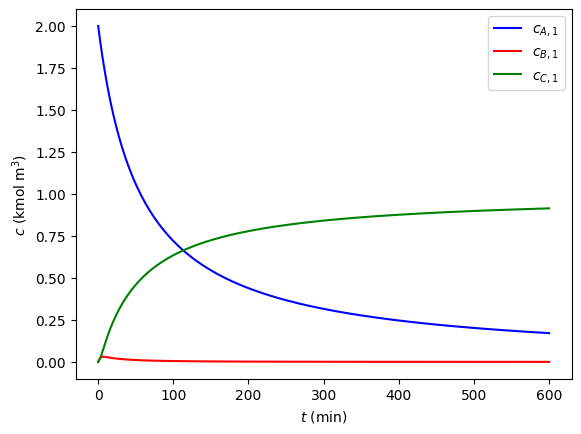

In [7]:
plt.xlabel('$t$ (min)')
plt.ylabel('$c$ (kmol m$^3$)')
plt.plot(results[:,0], results[:,1], "-b", label="$c_{A,1}$")
plt.plot(results[:,0], results[:,2], "-r", label="$c_{B,1}$")
plt.plot(results[:,0], results[:,3], "-g", label="$c_{C,1}$")
plt.legend(loc="best")
plt.show()

To simulate the two batch reactors connected in series, we define a separate DAG and introduce two external operations describing each reactor:

In [8]:
DAG = pymc.FFGraph()
OpIVP = cronos.FFODE()
IVP.options.DISPLEVEL = 0 # turn off display during numerical simulation
IVP.options.RESRECORD = 0 # turn off trajectory record

In [9]:
# reactor #1 initial concentrations
cA1_0 = pymc.FFVar(DAG, "cA1_0")
cB1_0 = pymc.FFVar(DAG, "cB1_0")
cC1_0 = pymc.FFVar(DAG, "cC1_0")

# reactor #1 parameters
tau1 = pymc.FFVar(DAG, "tau1")
T1   = pymc.FFVar(DAG, "T1")

# reactor #1 constants
kr11 = pymc.FFVar(DAG, "kr11")
Ea11 = pymc.FFVar(DAG, "Ea11")
kr21 = pymc.FFVar(DAG, "kr21")
Ea21 = pymc.FFVar(DAG, "Ea21")

[cA1_f,cB1_f,cC1_f] = OpIVP( [tau1,T1,cA1_0,cB1_0,cC1_0], [kr11,Ea11,kr21,Ea21], IVP )

cA1_f.set( "cA1_f" )
cB1_f.set( "cB1_f" )
cC1_f.set( "cC1_f" )
DAG.output( [cA1_f,cB1_f,cC1_f] )


OPERATIONS IN SUBGRAPH:
  tau1	<<  VARIABLE
  T1	<<  VARIABLE
  cA1_0	<<  VARIABLE
  cB1_0	<<  VARIABLE
  cC1_0	<<  VARIABLE
  kr11	<<  VARIABLE
  Ea11	<<  VARIABLE
  kr21	<<  VARIABLE
  Ea21	<<  VARIABLE
  cA1_f	<<  ODE[0xacbf890]( tau1, T1, cA1_0, cB1_0, cC1_0, kr11, Ea11, kr21, Ea21 )	[0]
  cB1_f	<<  ODE[0xacbf890]( tau1, T1, cA1_0, cB1_0, cC1_0, kr11, Ea11, kr21, Ea21 )	[1]
  cC1_f	<<  ODE[0xacbf890]( tau1, T1, cA1_0, cB1_0, cC1_0, kr11, Ea11, kr21, Ea21 )	[2]
DEPENDENTS IN SUBGRAPH:
  0:  cA1_f
  1:  cB1_f
  2:  cC1_f
WORK ARRAY SIZE: 21
MOVE ARRAY SIZE: 9


In [10]:
# reactor #2 initial concentrations
cC2_0 = pymc.FFVar(DAG, "cC2_0")

# reactor #2 parameters
tau2 = pymc.FFVar(DAG, "tau2")
T2   = pymc.FFVar(DAG, "T2")

# reactor #2 constants
kr12 = pymc.FFVar(DAG, "kr12")
Ea12 = pymc.FFVar(DAG, "Ea12")
kr22 = pymc.FFVar(DAG, "kr22")
Ea22 = pymc.FFVar(DAG, "Ea22")

[cA2_f,cB2_f,cC2_f] = OpIVP( [tau2,T2,cA1_f,cB1_f,cC2_0], [kr12,Ea12,kr22,Ea22], IVP )

cA2_f.set( "cA2_f" )
cB2_f.set( "cB2_f" )
cC2_f.set( "cC2_f" )
DAG.output( [cA2_f,cB2_f,cC2_f] )


OPERATIONS IN SUBGRAPH:
  tau2	<<  VARIABLE
  T2	<<  VARIABLE
  tau1	<<  VARIABLE
  T1	<<  VARIABLE
  cA1_0	<<  VARIABLE
  cB1_0	<<  VARIABLE
  cC1_0	<<  VARIABLE
  kr11	<<  VARIABLE
  Ea11	<<  VARIABLE
  kr21	<<  VARIABLE
  Ea21	<<  VARIABLE
  cA1_f	<<  ODE[0xacbf890]( tau1, T1, cA1_0, cB1_0, cC1_0, kr11, Ea11, kr21, Ea21 )	[0]
  cB1_f	<<  ODE[0xacbf890]( tau1, T1, cA1_0, cB1_0, cC1_0, kr11, Ea11, kr21, Ea21 )	[1]
  cC1_f	<<  ODE[0xacbf890]( tau1, T1, cA1_0, cB1_0, cC1_0, kr11, Ea11, kr21, Ea21 )	[2]
  cC2_0	<<  VARIABLE
  kr12	<<  VARIABLE
  Ea12	<<  VARIABLE
  kr22	<<  VARIABLE
  Ea22	<<  VARIABLE
  cA2_f	<<  ODE[0xacacc70]( tau2, T2, cA1_f, cB1_f, cC2_0, kr12, Ea12, kr22, Ea22 )	[0]
  cB2_f	<<  ODE[0xacacc70]( tau2, T2, cA1_f, cB1_f, cC2_0, kr12, Ea12, kr22, Ea22 )	[1]
  cC2_f	<<  ODE[0xacacc70]( tau2, T2, cA1_f, cB1_f, cC2_0, kr12, Ea12, kr22, Ea22 )	[2]
DEPENDENTS IN SUBGRAPH:
  0:  cA2_f
  1:  cB2_f
  2:  cC2_f
WORK ARRAY SIZE: 31
MOVE ARRAY SIZE: 9


Lastly, we define the two process outputs of interest:

In [11]:
xC1_f = cC1_f/(cA1_f+cB1_f+cC1_f)
xC1_f.set( "xC1_f" )

xB2_f = cB2_f/(cA2_f+cB2_f+cC2_f)
xB2_f.set( "xB2_f" )

In [12]:
import pygraphviz as pgv
from IPython.display import Image

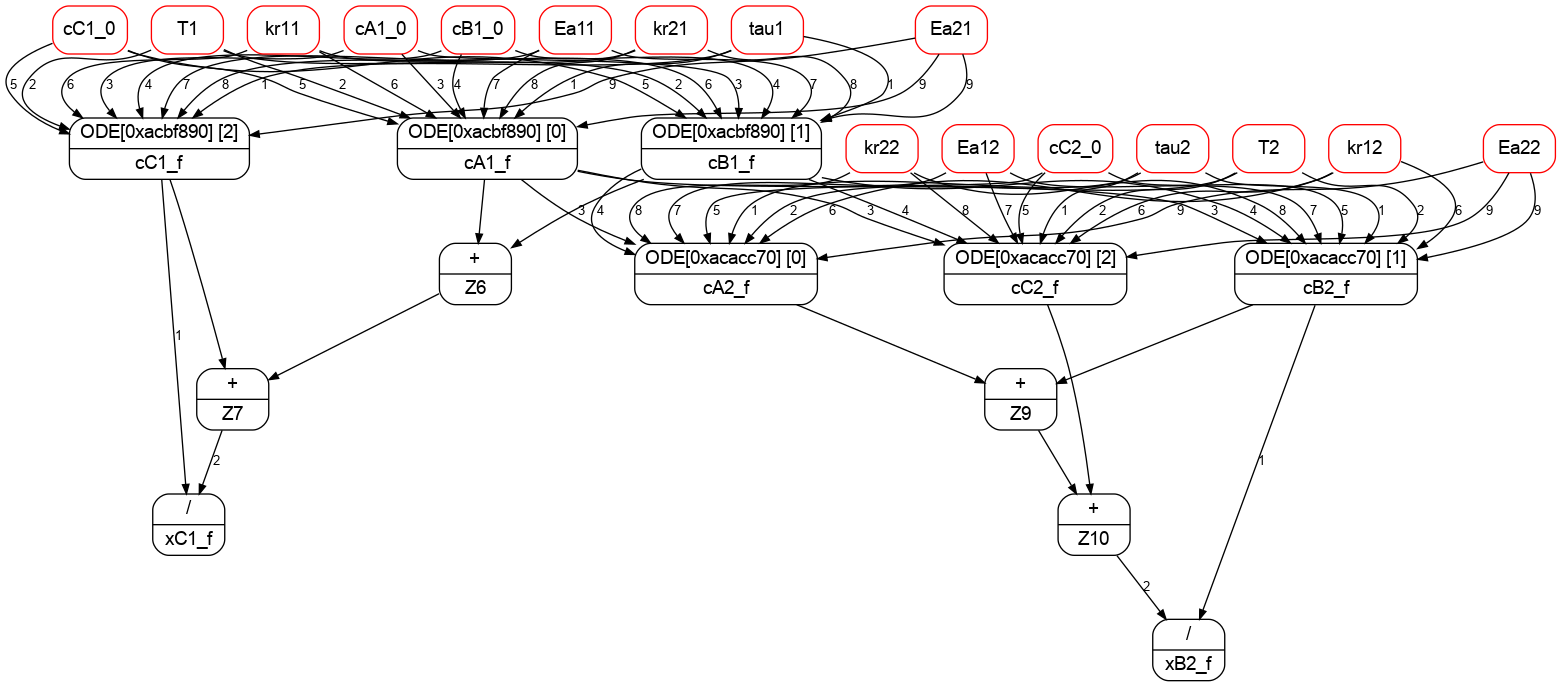

In [13]:
DAG.dot_script( [xC1_f,xB2_f], "output.dot" )

G = pgv.AGraph("output.dot")
G.draw("output.png", prog="dot")

fig = Image(filename=('output.png'))
fig

This DAG can be evaluated as any other DAG using the `eval` method:

In [14]:
[xC1_f_val,xB2_f_val] = DAG.eval( [xC1_f,xB2_f],
                                  [tau1,T1,tau2,T2,kr11,Ea11,kr21,Ea21,cA1_0,cB1_0,cC1_0,kr12,Ea12,kr22,Ea22,cC2_0],
                                  [400,800,400,800,6.66e-3,2.52e3,1.03,5e3,2,0,0,6.66e-3,2.52e3,1.03,5e3,0] )
print( "xC1_f =", xC1_f_val )
print( "xB2_f =", xB2_f_val )

xC1_f = 0.784349439121105
xB2_f = 0.0008380327455101892


Finally, we conduct multiple DAG evaluations over the operation domain $(T_i,\tau_i)\in [300,900] \times [300, 700]$:

In [15]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=4, scramble=False, seed=1)
samInput = sampler.random_base2(m=16) # 2^16 ~ 65,500 evaluations 
samInput[:,0] = 250 + samInput[:,0] * (800-250)
samInput[:,1] = 250 + samInput[:,1] * (1000-250)
samInput[:,2] = 250 + samInput[:,2] * (800-250)
samInput[:,3] = 250 + samInput[:,3] * (1000-250)

print( samInput )

[[250.         250.         250.         250.        ]
 [525.         625.         525.         625.        ]
 [662.5        437.5        387.5        437.5       ]
 ...
 [662.50839233 812.48855591 697.58834839 633.84628296]
 [525.00839233 624.98855591 285.08834839 446.34628296]
 [250.00839233 999.98855591 560.08834839 821.34628296]]


In [16]:
DAG.options.MAXTHREAD = 0 # use all available threads
samOutput = DAG.veval( [xC1_f,xB2_f], [tau1,T1,tau2,T2], samInput.tolist(),
                       [kr11,Ea11,kr21,Ea21,cA1_0,cB1_0,cC1_0,kr12,Ea12,kr22,Ea22,cC2_0],
                       [6.66e-3,2.52e3,1.03,5e3,2,0,0,6.66e-3,2.52e3,1.03,5e3,0],
                       walltime=True )

print( np.array(samOutput) )

[[4.90002694e-01 6.55947628e-03]
 [8.11111971e-01 7.91254695e-04]
 [8.14799227e-01 1.35599580e-03]
 ...
 [8.58492877e-01 5.84436498e-04]
 [8.11112819e-01 1.56906530e-03]
 [7.10067278e-01 6.12150190e-04]]


vectorized DAG evaluation on 0 threads: 3.11156 sec


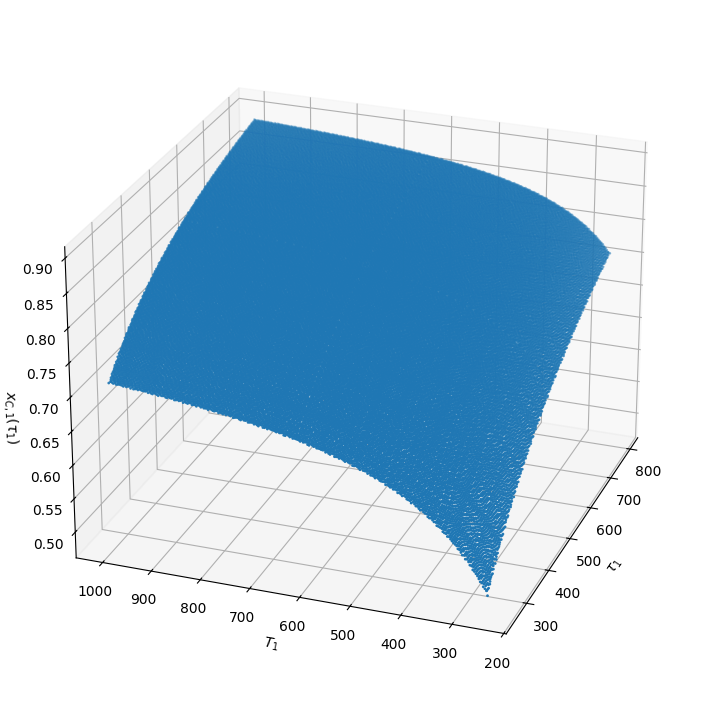

In [17]:
samOutput = np.array( np.array(samOutput) )

fig = plt.figure(figsize =(14,9))
ax = plt.axes(projection ='3d')
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$T_1$')
ax.set_zlabel(r'$x_{C,1}(\tau_1)$')

ax.scatter(samInput[:,0], samInput[:,1], samOutput[:,0], s=1)
ax.view_init(elev=25, azim=200)

plt.show()

We can also evaluate the derivatives of the two outputs $x_{C,1}, x_{B,2}$ with respect to any of the inputs $\tau_1,T_1,\tau_2,T_2$:

In [26]:
[Row,Col,Grad] = DAG.fdiff( [xC1_f,xB2_f], [tau1,T1,tau2,T2] )
print( "Row:", Row )
print( "Col:", Col )
#print( "Grad:", Grad )
#DAG.output( Grad )

Grad_val = DAG.eval( Grad,
                     [tau1,T1,tau2,T2,kr11,Ea11,kr21,Ea21,cA1_0,cB1_0,cC1_0,kr12,Ea12,kr22,Ea22,cC2_0],
                     [400,800,400,800,6.66e-3,2.52e3,1.03,5e3,2,0,0,6.66e-3,2.52e3,1.03,5e3,0] )
print( "Grad =", Grad_val )

Row: [0, 1, 0, 1, 1, 1]
Col: [0, 0, 1, 1, 2, 3]
Grad = [0.00042421883213971154, -4.1595279123861456e-07, 8.059497490633952e-05, -7.762596582180223e-08, -1.6260202708472255e-06, -7.005240181340423e-07]
